In [1]:
import random

import flax
import flax.linen as nn
import jax
import jax.numpy as jnp
import numpy as np
import optax
from flax.training.train_state import TrainState
from stable_baselines3.common.buffers import ReplayBuffer

import matplotlib.pyplot as plt
import plotly.graph_objects as go
from tqdm.auto import trange

from myenv import MyEnv
from base_rl_mcmc.distributions import Distribution

import toml
from typing import Sequence
from types import SimpleNamespace

config = toml.load("./base_rl_mcmc/config/config_td3.toml")
args = SimpleNamespace(**config)

# seeding
random.seed(args.seed)
np.random.seed(args.seed)
key = jax.random.PRNGKey(args.seed)
key, actor_key, qf1_key, qf2_key = jax.random.split(key, 4)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [2]:
# Initialize Agent
class QNetwork(nn.Module):
    """
    Critic Network
    """
    @nn.compact
    def __call__(self, x: jnp.ndarray, a: jnp.ndarray):
        x = jnp.concatenate([x, a], -1)
        x = nn.Dense(48)(x)
        x = nn.softplus(x)
        x = nn.Dense(48)(x)
        x = nn.Dense(1)(x)
        x = nn.softplus(x)
        return x

class Actor(nn.Module):
    """
    Actor Network
    """
    action_dim: Sequence[int]

    @nn.compact
    def __call__(self, x):
        x = nn.Dense(48)(x)
        x = nn.softplus(x)
        x = nn.Dense(48)(x)
        x = nn.Dense(self.action_dim)(x)
        x = nn.softplus(x)
        return x

In [3]:
class TrainState(TrainState):
    target_params: flax.core.FrozenDict

In [4]:
# Setup env
log_p = Distribution.gaussian1D
dim = 1
max_steps=10_000

env = MyEnv(log_p, dim, max_steps)
max_action = float(env.action_space.high[0])
env.observation_space.dtype = np.float32
rb = ReplayBuffer(
    args.buffer_size,
    env.observation_space,
    env.action_space,
    device='cpu',
    handle_timeout_termination=False,
)

In [5]:
# Start
obs, _ = env.reset()

actor = Actor(action_dim=env.dim)
qf = QNetwork()

actor_state = TrainState.create(
    apply_fn=actor.apply,
    params=actor.init(actor_key, obs),
    target_params=actor.init(actor_key, obs),
    tx=optax.adam(learning_rate=args.learning_rate),
)

qf1_state = TrainState.create(
    apply_fn=qf.apply,
    params=qf.init(qf1_key, obs, env.action_space.sample()),
    target_params=qf.init(qf1_key, obs, env.action_space.sample()),
    tx=optax.adam(learning_rate=args.learning_rate)
    )
qf2_state = TrainState.create(
    apply_fn=qf.apply,
    params=qf.init(qf1_key, obs, env.action_space.sample()),
    target_params=qf.init(qf1_key, obs, env.action_space.sample()),
    tx=optax.adam(learning_rate=args.learning_rate)
    )

In [6]:
actor.apply = jax.jit(actor.apply)
qf.apply = jax.jit(qf.apply)

In [7]:
@jax.jit
def update_critic(
    actor_state: TrainState,
    qf1_state: TrainState,
    qf2_state: TrainState,
    observations: np.ndarray,
    actions: np.ndarray,
    next_observations: np.ndarray,
    rewards: np.ndarray,
    dones: np.ndarray,
    key: jnp.ndarray,
):
    key, noise_key = jax.random.split(key, 2)
    clipped_noise = (
        jnp.clip(
            (jax.random.normal(noise_key, actions.shape) * args.policy_noise),
            -args.noise_clip,
            args.noise_clip,
        )
    )
    next_state_actions = jnp.clip(
        actor.apply(actor_state.target_params, next_observations) + clipped_noise,
        env.action_space.low[0],
        env.action_space.high[0],
    )
    qf1_next_target = qf.apply(qf1_state.target_params, next_observations, next_state_actions).reshape(-1)
    qf2_next_target = qf.apply(qf2_state.target_params, next_observations, next_state_actions).reshape(-1)
    min_qf_next_target = jnp.minimum(qf1_next_target, qf2_next_target)
    next_q_value = (rewards + (1 - dones) * args.gamma * (min_qf_next_target)).reshape(-1)

    def mse_loss(params):
        qf_a_values = qf.apply(params, observations, actions).squeeze()
        return ((qf_a_values - next_q_value) ** 2).mean(), qf_a_values.mean()

    (qf1_loss_value, qf1_a_values), grads1 = jax.value_and_grad(mse_loss, has_aux=True)(qf1_state.params)
    (qf2_loss_value, qf2_a_values), grads2 = jax.value_and_grad(mse_loss, has_aux=True)(qf2_state.params)
    qf1_state = qf1_state.apply_gradients(grads=grads1)
    qf2_state = qf2_state.apply_gradients(grads=grads2)

    return (qf1_state, qf2_state), (qf1_loss_value, qf2_loss_value), (qf1_a_values, qf2_a_values), key


In [8]:
@jax.jit
def update_actor(
    actor_state: TrainState,
    qf1_state: TrainState,
    qf2_state: TrainState,
    observations: np.ndarray,
):
    def actor_loss(params):
        return -qf.apply(qf1_state.params, observations, actor.apply(params, observations)).mean()

    actor_loss_value, grads = jax.value_and_grad(actor_loss)(actor_state.params)
    actor_state = actor_state.apply_gradients(grads=grads)
    actor_state = actor_state.replace(
        target_params=optax.incremental_update(actor_state.params, actor_state.target_params, args.tau)
        )

    qf1_state = qf1_state.replace(
        target_params=optax.incremental_update(qf1_state.params, qf1_state.target_params, args.tau)
        )
    qf2_state = qf2_state.replace(
        target_params=optax.incremental_update(qf2_state.params, qf2_state.target_params, args.tau)
        )
    return actor_state, (qf1_state, qf2_state), actor_loss_value

In [9]:
for global_step in trange(args.total_timesteps):

    actions = actor.apply(actor_state.params, obs)
    actions = np.array(
        [
            (actions + np.random.normal(0, args.exploration_noise)).clip(
                env.action_space.low, env.action_space.high
            )
        ]
    )

    next_obs, rewards, terminateds, truncateds, infos = env.step(actions, lambda x: actor.apply(actor_state.params, x))

    real_next_obs = next_obs.copy()
    rb.add(obs, real_next_obs, actions, rewards, terminateds, infos)

    obs = next_obs

    # Training
    if global_step > args.learning_starts:
        data = rb.sample(args.batch_size)

        (qf1_state, qf2_state), (qf1_loss_value, qf2_loss_value), (qf1_a_values, qf2_a_values), key = update_critic(
            actor_state,
            qf1_state,
            qf2_state,
            data.observations.numpy(),
            data.actions.numpy(),
            data.next_observations.numpy(),
            data.rewards.flatten().numpy(),
            data.dones.flatten().numpy(),
            key,
        )

        if global_step % args.policy_frequency == 0:
            actor_state, (qf1_state, qf2_state), actor_loss_value = update_actor(
                actor_state,
                qf1_state,
                qf2_state,
                data.observations.numpy(),
            )

    # ESJD
    if global_step % 100 == 0 and global_step > 0:
        env.expected_squared_jump_distance(lambda x: actor.apply(actor_state.params, np.array([x])))
 

  0%|          | 0/10000 [00:00<?, ?it/s]

/home/congye/Code/PythonProjects/LearningAdaptiveMCMC/Python/myenv.py:152: RuntimeWarning: divide by zero encountered in log
  return np.log(np.power(np.linalg.norm(np.array([x_t]) - np.array([x_t_plus_1]), 2), 2))
/home/congye/Software/anaconda3/envs/rl/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/home/congye/Software/anaconda3/envs/rl/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from split

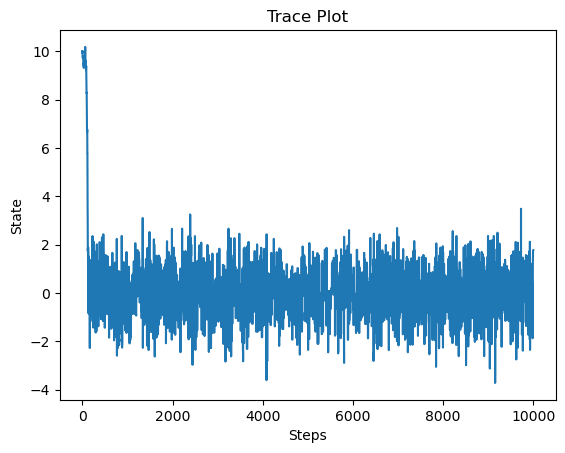

In [10]:
# Trace Plot
plt.plot(env.store_state)
plt.title("Trace Plot")
plt.xlabel("Steps")
plt.ylabel("State")
plt.show()

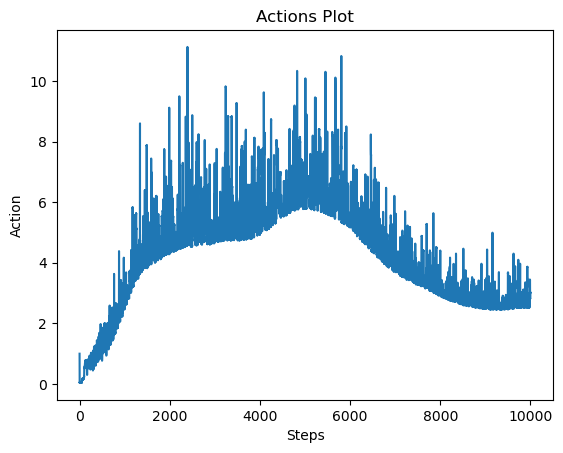

In [11]:
# Action Plot
plt.plot([i.squeeze() for i in env.store_action])
plt.title("Actions Plot")
plt.xlabel("Steps")
plt.ylabel("Action")
plt.show()

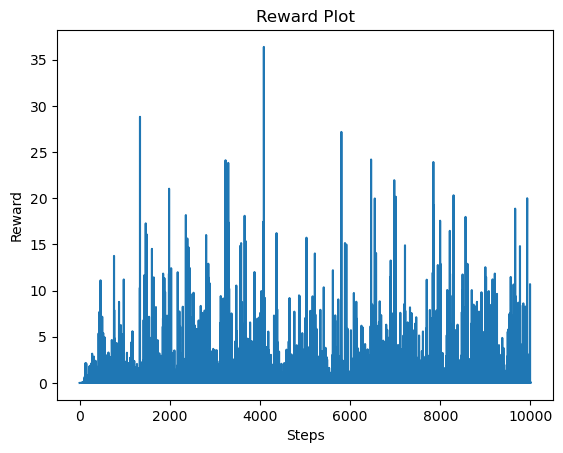

In [12]:
# Immediate Reward Plot
plt.plot(env.store_reward)
plt.title("Reward Plot")
plt.xlabel("Steps")
plt.ylabel("Reward")
plt.show()

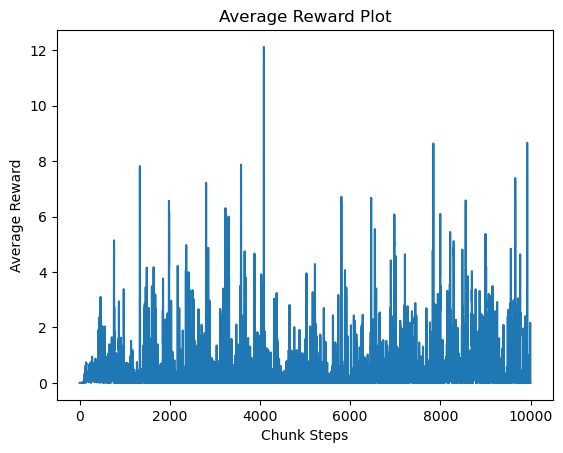

In [13]:
# Average Reward Plot
kernel = np.ones(5) / 5
averages = np.convolve(env.store_reward, kernel, mode='valid')

plt.plot(averages)
plt.title('Average Reward Plot')
plt.xlabel('Chunk Steps')
plt.ylabel('Average Reward')
plt.show()

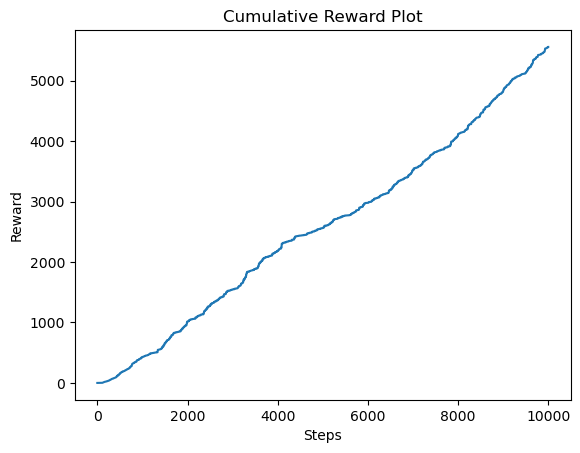

In [14]:
# Cumulative Reward Plot
plt.plot(np.cumsum(env.store_reward))
plt.title("Cumulative Reward Plot")
plt.xlabel("Steps")
plt.ylabel("Reward")
plt.show()

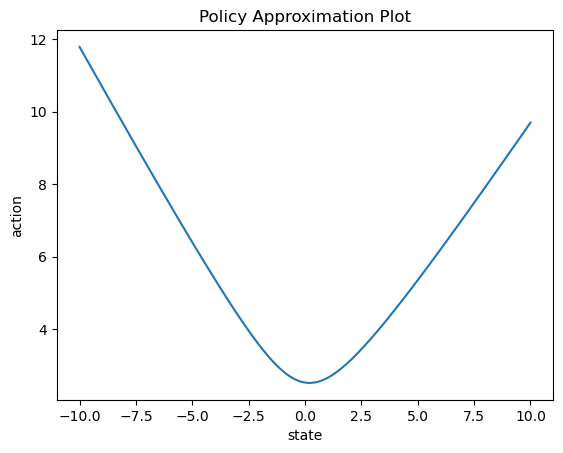

In [15]:
# Policy Plot
x = np.linspace(-10, 10, 1000)
policy_action = actor.apply(actor_state.params, x.reshape(-1, 1))
plt.plot(x, policy_action)

plt.title('Policy Approximation Plot')
plt.xlabel('state')
plt.ylabel('action')

plt.show()

In [16]:
# Q approximation Plot
x = np.linspace(-10, 10, 1000)
a = np.linspace(0, 10, 1000)
Z = np.zeros((len(x), len(a)))

for i, x_i in enumerate(x):
    for j, a_i in enumerate(a):
        Z[i, j] = qf.apply(qf1_state.params, jnp.array([x_i]), jnp.array([a_i]))

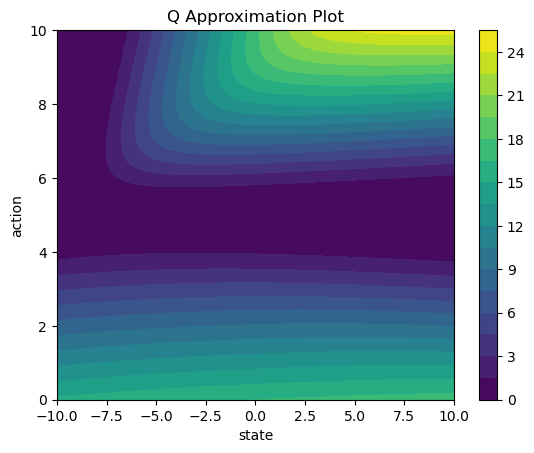

In [17]:
X, A = np.meshgrid(x, a)
plt.contourf(X, A, Z, 20)
plt.colorbar()

plt.title('Q Approximation Plot')
plt.xlabel('state')
plt.ylabel('action')

plt.show()

In [ ]:
fig = go.Figure(data=[go.Surface(z=Z, x=X, y=A, colorscale='Viridis')])
fig.update_layout(scene=dict(xaxis_title='State',
                             yaxis_title='Action',
                             zaxis_title='Value'))

fig.show()

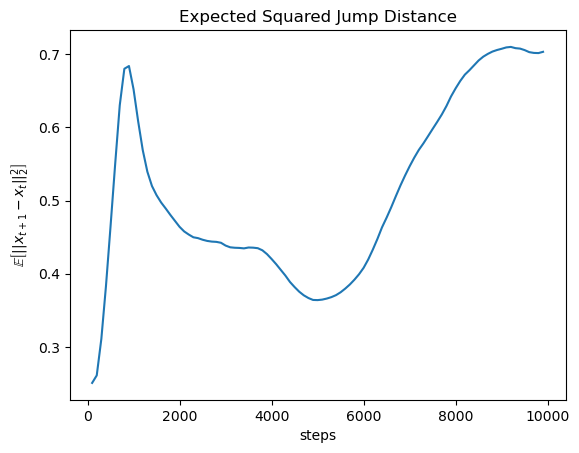

In [19]:
# ESJD Plot
esjd_iteration = np.linspace(100, 100 + (len(env.store_esjd) - 1) * 100, len(env.store_esjd))
esjd = np.array([env.store_esjd]).flatten()
esjd_plot_include_nan = np.column_stack((esjd_iteration, esjd))
esjd_plot = esjd_plot_include_nan[~np.isnan(esjd_plot_include_nan[:, 1])]

plt.plot(esjd_plot[:,0], esjd_plot[:,1])

plt.title('Expected Squared Jump Distance')
plt.xlabel('steps')
plt.ylabel(r'$\mathbb{E}\left[||x_{t+1} - x_{t}||_{2}^{2}\right]$')

plt.show()